<a href="https://www.kaggle.com/code/mustafaatakanyucel/ensemble-learning?scriptVersionId=259723998" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Seaborn için Türkçe font desteği
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')

# Örnek veri seti oluşturma (veya Wine dataset kullanma)
# Sentetik veri
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

# Veya gerçek veri seti
# wine = load_wine()
# X, y = wine.data, wine.target

# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Veri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Eğitim veri boyutu: {X_train.shape}")
print(f"Test veri boyutu: {X_test.shape}")
print(f"Sınıf dağılımı: {np.bincount(y_train)}")

Eğitim veri boyutu: (800, 20)
Test veri boyutu: (200, 20)
Sınıf dağılımı: [402 398]


Logistic Regression: 0.821 (+/- 0.053)
SVM: 0.948 (+/- 0.036)
Decision Tree: 0.778 (+/- 0.037)
KNN: 0.953 (+/- 0.017)
Hard Voting: 0.925 (+/- 0.035)
Soft Voting: 0.926 (+/- 0.022)


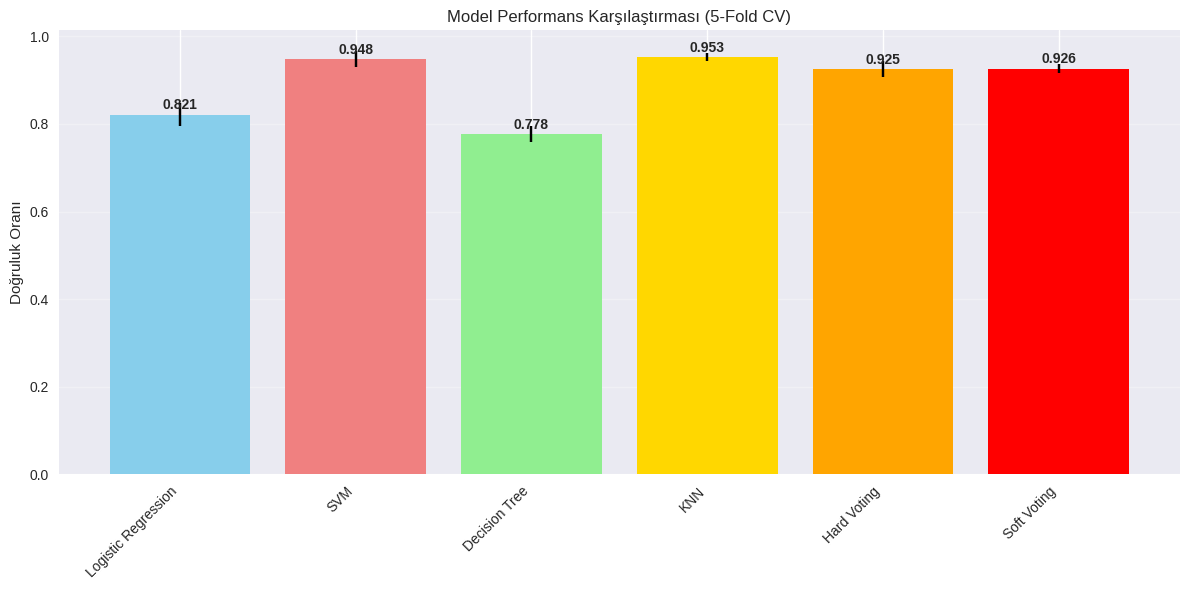

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Temel modeller oluşturma
lr_clf = LogisticRegression(random_state=42)
svc_clf = SVC(probability=True, random_state=42)  # probability=True önemli!
dt_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Hard Voting Classifier
hard_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svc', svc_clf),
        ('dt', dt_clf),
        ('knn', knn_clf)
    ],
    voting='hard'
)

# Soft Voting Classifier
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svc', svc_clf),
        ('dt', dt_clf),
        ('knn', knn_clf)
    ],
    voting='soft'
)

# Modelleri eğitme ve karşılaştırma
models = {
    'Logistic Regression': lr_clf,
    'SVM': svc_clf,
    'Decision Tree': dt_clf,
    'KNN': knn_clf,
    'Hard Voting': hard_voting_clf,
    'Soft Voting': soft_voting_clf
}

results = {}
for name, model in models.items():
    # Cross-validation ile daha güvenilir sonuçlar
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name}: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Sonuçları görselleştirme
plt.figure(figsize=(12, 6))
names = list(results.keys())
means = [results[name]['mean'] for name in names]
stds = [results[name]['std'] for name in names]

bars = plt.bar(names, means, yerr=stds, capsize=5, 
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'red'])
plt.ylabel('Doğruluk Oranı')
plt.title('Model Performans Karşılaştırması (5-Fold CV)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Bar üzerinde değerleri gösterme
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Out-of-Bag Score: 0.895
Test Accuracy: 0.905

Tek Ağaç Accuracy: 0.780
Bagging Accuracy: 0.905
İyileşme: 0.125


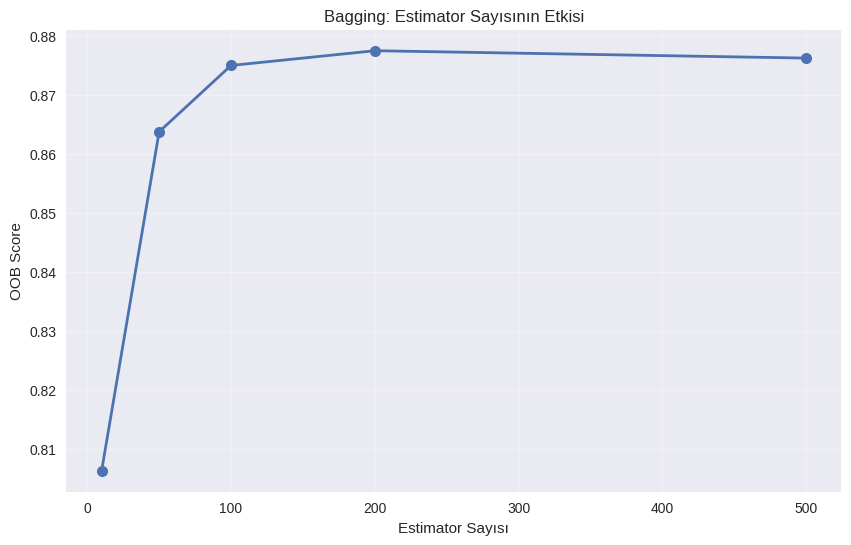

In [4]:
from sklearn.ensemble import BaggingClassifier

# Bagging Classifier oluşturma
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    oob_score=True,  # Out-of-bag scoring
    random_state=42,
    n_jobs=-1
)

# Modeli eğitme
bagging_clf.fit(X_train_scaled, y_train)

# Out-of-bag skoru
print(f"Out-of-Bag Score: {bagging_clf.oob_score_:.3f}")

# Test seti üzerinde değerlendirme
bagging_pred = bagging_clf.predict(X_test_scaled)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
print(f"Test Accuracy: {bagging_accuracy:.3f}")

# Tek bir ağaç ile karşılaştırma
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train_scaled, y_train)
single_pred = single_tree.predict(X_test_scaled)
single_accuracy = accuracy_score(y_test, single_pred)

print(f"\nTek Ağaç Accuracy: {single_accuracy:.3f}")
print(f"Bagging Accuracy: {bagging_accuracy:.3f}")
print(f"İyileşme: {bagging_accuracy - single_accuracy:.3f}")

# Estimator sayısının etkisi
estimator_range = [10, 50, 100, 200, 500]
bagging_scores = []

for n_est in estimator_range:
    bag_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_est,
        oob_score=True,
        random_state=42
    )
    bag_clf.fit(X_train_scaled, y_train)
    bagging_scores.append(bag_clf.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(estimator_range, bagging_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Estimator Sayısı')
plt.ylabel('OOB Score')
plt.title('Bagging: Estimator Sayısının Etkisi')
plt.grid(True, alpha=0.3)
plt.show()

Random Forest OOB Score: 0.896
Random Forest Test Accuracy: 0.915


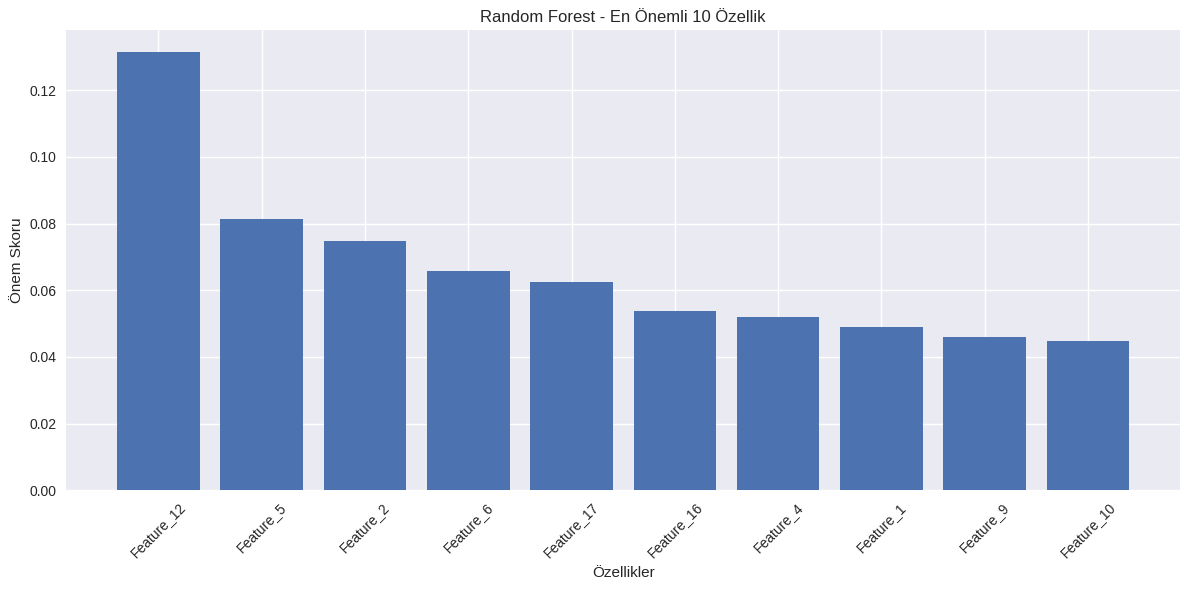

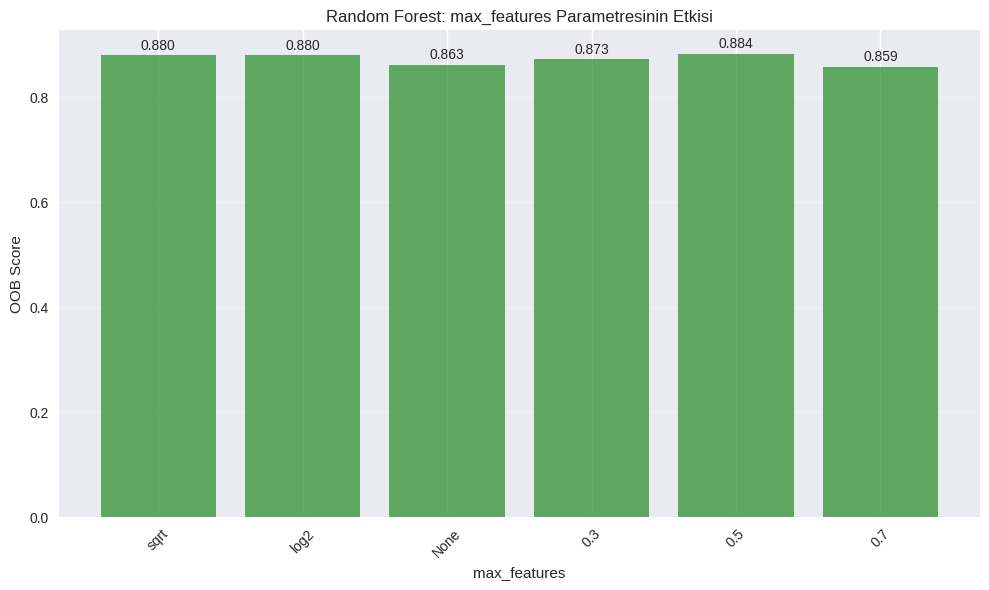

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest oluşturma
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Modeli eğitme
rf_clf.fit(X_train_scaled, y_train)

# Skorları yazdırma
print(f"Random Forest OOB Score: {rf_clf.oob_score_:.3f}")

rf_pred = rf_clf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Test Accuracy: {rf_accuracy:.3f}")

# Özellik önemlilik analizi
feature_importances = rf_clf.feature_importances_
feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

# Top 10 önemli özellik
indices = np.argsort(feature_importances)[::-1][:10]

plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importances[indices])
plt.xlabel('Özellikler')
plt.ylabel('Önem Skoru')
plt.title('Random Forest - En Önemli 10 Özellik')
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Farklı max_features değerlerinin etkisi
max_features_options = ['sqrt', 'log2', None, 0.3, 0.5, 0.7]
rf_scores = []

for max_feat in max_features_options:
    rf_temp = RandomForestClassifier(
        n_estimators=50,
        max_features=max_feat,
        oob_score=True,
        random_state=42
    )
    rf_temp.fit(X_train_scaled, y_train)
    rf_scores.append(rf_temp.oob_score_)

plt.figure(figsize=(10, 6))
x_labels = [str(x) for x in max_features_options]
plt.bar(x_labels, rf_scores, color='forestgreen', alpha=0.7)
plt.xlabel('max_features')
plt.ylabel('OOB Score')
plt.title('Random Forest: max_features Parametresinin Etkisi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Bar üzerinde değerleri gösterme
for i, score in enumerate(rf_scores):
    plt.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Parametre aralıkları
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# En iyi parametreleri bulma
rf_random.fit(X_train_scaled, y_train)

print("En İyi Parametreler:")
for param, value in rf_random.best_params_.items():
    print(f"{param}: {value}")

print(f"\nEn İyi CV Skoru: {rf_random.best_score_:.3f}")

# En iyi modeli test etme
best_rf = rf_random.best_estimator_
best_pred = best_rf.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, best_pred)
print(f"Optimize Edilmiş RF Test Accuracy: {best_accuracy:.3f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
En İyi Parametreler:
n_estimators: 100
min_samples_split: 5
min_samples_leaf: 2
max_features: log2
max_depth: None
bootstrap: False

En İyi CV Skoru: 0.900
Optimize Edilmiş RF Test Accuracy: 0.920


AdaBoost Test Accuracy: 0.845


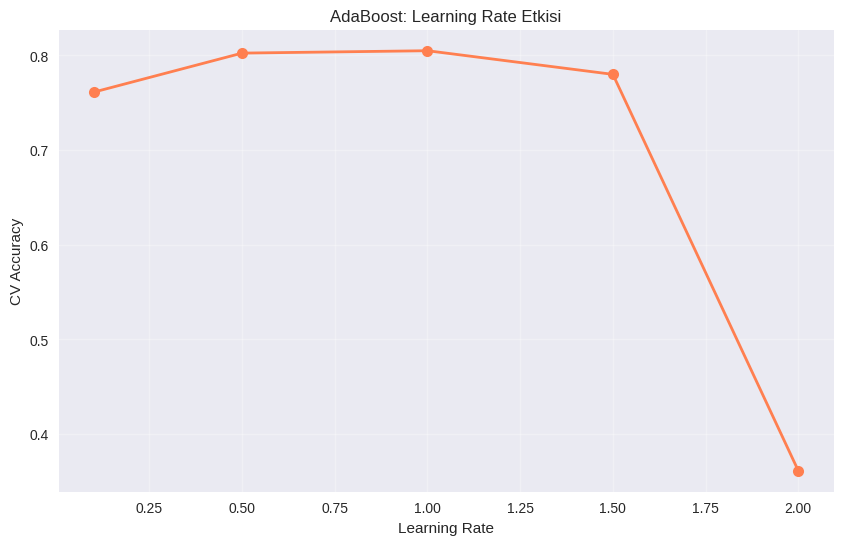

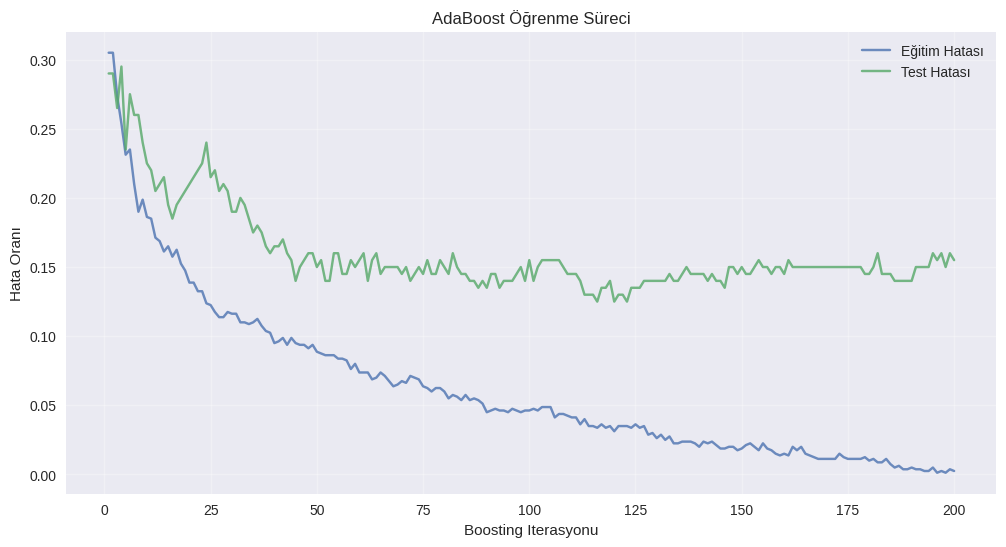

In [7]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Stump ağaçlar
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME.R',  # Probabilistic SAMME
    random_state=42
)

ada_clf.fit(X_train_scaled, y_train)

# Performans değerlendirme
ada_pred = ada_clf.predict(X_test_scaled)
ada_accuracy = accuracy_score(y_test, ada_pred)
print(f"AdaBoost Test Accuracy: {ada_accuracy:.3f}")

# Learning rate'in etkisi
learning_rates = [0.1, 0.5, 1.0, 1.5, 2.0]
ada_scores = []

for lr in learning_rates:
    ada_temp = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=lr,
        random_state=42
    )
    cv_scores = cross_val_score(ada_temp, X_train_scaled, y_train, cv=3)
    ada_scores.append(cv_scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, ada_scores, marker='o', linewidth=2, markersize=8, color='coral')
plt.xlabel('Learning Rate')
plt.ylabel('CV Accuracy')
plt.title('AdaBoost: Learning Rate Etkisi')
plt.grid(True, alpha=0.3)
plt.show()

# Öğrenme sürecini gözlemleme
ada_clf_staged = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)

ada_clf_staged.fit(X_train_scaled, y_train)

# Staged predictions
train_errors = []
test_errors = []

for train_pred, test_pred in zip(
    ada_clf_staged.staged_predict(X_train_scaled),
    ada_clf_staged.staged_predict(X_test_scaled)
):
    train_errors.append(1 - accuracy_score(y_train, train_pred))
    test_errors.append(1 - accuracy_score(y_test, test_pred))

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Eğitim Hatası', alpha=0.8)
plt.plot(range(1, len(test_errors) + 1), test_errors, label='Test Hatası', alpha=0.8)
plt.xlabel('Boosting Iterasyonu')
plt.ylabel('Hata Oranı')
plt.title('AdaBoost Öğrenme Süreci')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Gradient Boosting Test Accuracy: 0.905


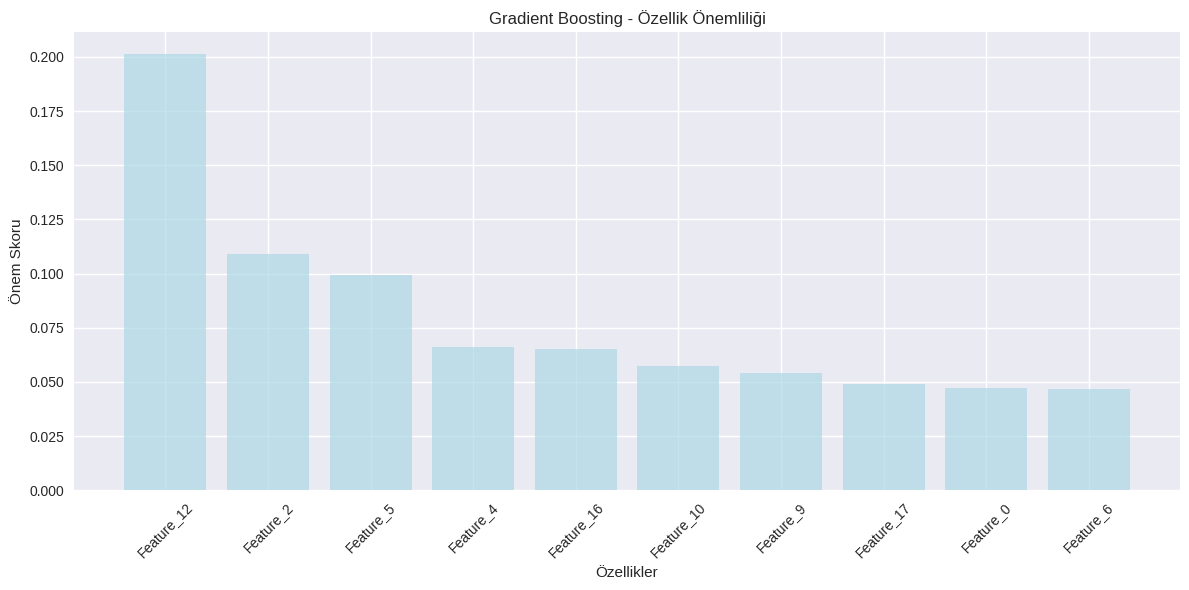

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_clf.fit(X_train_scaled, y_train)

gb_pred = gb_clf.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Test Accuracy: {gb_accuracy:.3f}")

# Feature importance
gb_importance = gb_clf.feature_importances_
indices = np.argsort(gb_importance)[::-1][:10]

plt.figure(figsize=(12, 6))
plt.bar(range(10), gb_importance[indices], color='lightblue', alpha=0.7)
plt.xlabel('Özellikler')
plt.ylabel('Önem Skoru')
plt.title('Gradient Boosting - Özellik Önemliliği')
plt.xticks(range(10), [f'Feature_{i}' for i in indices], rotation=45)
plt.tight_layout()
plt.show()

Random Forest:
  CV Score: 0.894 (+/- 0.052)
  Test Score: 0.925
  Execution Time: 1.71 saniye

AdaBoost:
  CV Score: 0.807 (+/- 0.049)
  Test Score: 0.845
  Execution Time: 2.02 saniye

Gradient Boosting:
  CV Score: 0.879 (+/- 0.036)
  Test Score: 0.905
  Execution Time: 2.95 saniye

Bagging:
  CV Score: 0.860 (+/- 0.027)
  Test Score: 0.915
  Execution Time: 4.96 saniye

Soft Voting:
  CV Score: 0.926 (+/- 0.022)
  Test Score: 0.915
  Execution Time: 1.14 saniye



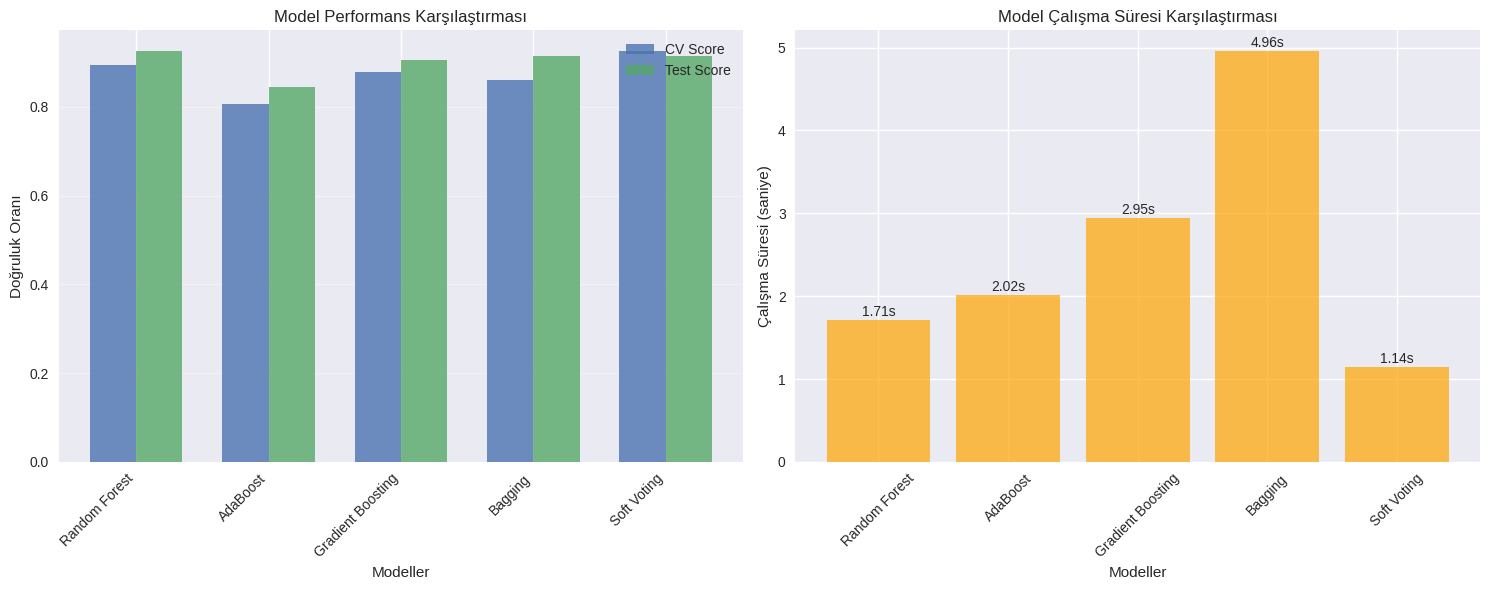


 En İyi Model: Random Forest
Test Doğruluğu: 0.925


In [9]:
# Tüm ensemble modellerini karşılaştırma
final_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
    'Soft Voting': soft_voting_clf
}

final_results = {}
execution_times = {}

import time

for name, model in final_models.items():
    start_time = time.time()
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Modeli eğitme ve test etme
    model.fit(X_train_scaled, y_train)
    test_pred = model.predict(X_test_scaled)
    test_score = accuracy_score(y_test, test_pred)
    
    end_time = time.time()
    
    final_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_score': test_score
    }
    execution_times[name] = end_time - start_time
    
    print(f"{name}:")
    print(f"  CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"  Test Score: {test_score:.3f}")
    print(f"  Execution Time: {end_time - start_time:.2f} saniye")
    print()

# Sonuçları görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
names = list(final_results.keys())
cv_means = [final_results[name]['cv_mean'] for name in names]
test_scores = [final_results[name]['test_score'] for name in names]

x = np.arange(len(names))
width = 0.35

ax1.bar(x - width/2, cv_means, width, label='CV Score', alpha=0.8)
ax1.bar(x + width/2, test_scores, width, label='Test Score', alpha=0.8)
ax1.set_xlabel('Modeller')
ax1.set_ylabel('Doğruluk Oranı')
ax1.set_title('Model Performans Karşılaştırması')
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Execution time comparison
times = [execution_times[name] for name in names]
bars = ax2.bar(names, times, color='orange', alpha=0.7)
ax2.set_xlabel('Modeller')
ax2.set_ylabel('Çalışma Süresi (saniye)')
ax2.set_title('Model Çalışma Süresi Karşılaştırması')
ax2.tick_params(axis='x', rotation=45)

# Bar üzerinde değerleri gösterme
for bar, time_val in zip(bars, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time_val:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# En iyi performans gösteren modeli bulma
best_model = max(final_results, key=lambda x: final_results[x]['test_score'])
print(f"\n En İyi Model: {best_model}")
print(f"Test Doğruluğu: {final_results[best_model]['test_score']:.3f}")

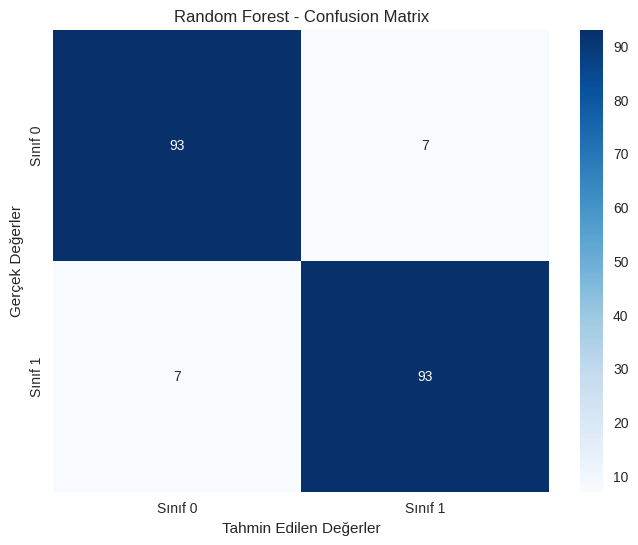

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       100
           1       0.93      0.93      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



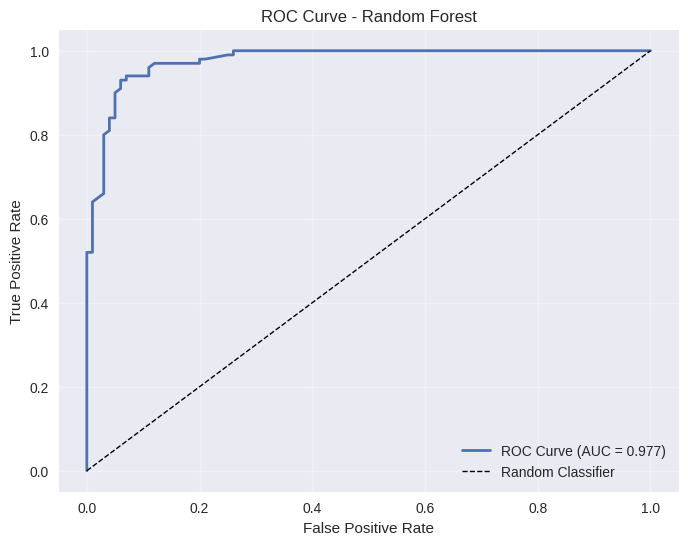

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# En iyi modeli seçelim (örnek olarak Random Forest)
best_rf = RandomForestClassifier(n_estimators=200, random_state=42)
best_rf.fit(X_train_scaled, y_train)
rf_predictions = best_rf.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

# ROC Curve ve AUC
from sklearn.metrics import roc_curve, auc

# Probability predictions
rf_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()